# Introduction to Deep Learning for Derivatives Pricing

Author: Sebastien Gurrieri, sebgur@gmail.com


[[J. Kienitz]](https://finciraptor.de/wp-content/uploads/2020/05/Slides_Webinar_WBS.pdf) 

[[Hernandez 2016]](https://www.risk.net/media/download/952386/download)

[[Gurrieri 2023]](https://colab.research.google.com/drive/1y-Tb4JxiBmcJAw943GWtZn_GiGhcUUzS?usp=sharing)

### Presentation plan

* Introduction: concept of complex models with slow/difficult closed-forms, pricing MC/PDE, specifying to Stochastic Vol

* Example of process: SABR (super fast), number of iterations, calculation by MC, estimation of runtime for optimization on MC

* Discussion on what can be done to improve runtime: use better language (C#, C++)? Parallelize? Use GPUs? Use optimization tricks? Use of approximations to the closed-form?

* Direct Map: concept of using the network as an approximate closed-form, with the advantage of not having to find new analytics every time. Still: need to optimize.

* Inverse Map: concept of skipping optimization, on-going research

### SDevPy package
We start by installing our package SDevPy that provides helper function to generate the datasets and train the models. For details of how this is done, note that the package is [open source and available here](https://pypi.org/project/sdevpy/). The ML engine behind it is Keras.

In [7]:
# Import relevant modules
import os, sys
from datetime import datetime
import numpy as np
from platform import python_version
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Add SDevPy location to path
sdev_path = r"C:\Code\SDev.Python"
if sdev_path not in sys.path:
    if os.path.exists(sdev_path):
        sys.path.append(sdev_path)
    else:
        print("Path to SDevPy not found: " + sdev_path)

# Alternatively, install SDevPy from online package
# !pip install sdevpy --upgrade -q

import sdevpy as sd
from sdevpy.tools.timer import Stopwatch
from sdevpy.tools import filemanager
from sdevpy.volsurfacegen import stovolfactory
from sdevpy.machinelearning import datasets
from sdevpy.machinelearning.topology import compose_model
from sdevpy.machinelearning.learningmodel import LearningModel, load_learning_model
from sdevpy.machinelearning.learningschedules import FlooredExponentialDecay, CyclicalExponentialDecay
from sdevpy.maths.metrics import bps_rmse, tf_bps_rmse, tf_mse, mse, tf_rmse, rmse
from sdevpy.machinelearning.callbacks import RefCallback

print("Python version: " + python_version())
print("NumPy version: " + np.__version__)
print("TensorFlow version: " + tf.__version__)
print("SDevPy version: " + sd.__version__)

Python version: 3.11.6
NumPy version: 1.26.4
TensorFlow version: 2.17.0
SDevPy version: 1.0.3


## 1) Classic Vanilla/Exotic Option Valuation

Insert pricing chart image
![title](../notebooks/img/DeepLearningCalibration/testimage.png)

## 2) Deep Learning for Pricing

## 3) Deep Learning for Calibration

### Training?
We need to set various runtime configurations. The most important ones here are:
* USE_PRETRAINED: set to true in order to start from a pre-trained model. You must then specify the ID of the chosen model. The code below will download a single pre-trained model whose ID is 'SABR'. You can train and save your own models, give them an ID, and then restart training later by providing the corresponding ID. If set to false, then an entirely new model will be trained (TRAIN must then be true)
* TRAIN: set to true to train/retrain the model
* GENERATE_MORE_SAMPLES: set to true to generate additional samples on top of those provided by download

In [ ]:
# Global settings (do not change if using downloaded pre-trained models)
USE_PRETRAINED = True
PRETRAINED_MODEL_ID = 'SABR'
TRAIN = False
GENERATE_MORE_SAMPLES = False
SHIFT = 0.03 # For negative rates
SPREADS = [-200, -100, -75, -50, -25, -10, 0, 10, 25, 50, 75, 100, 200] # Do not change when using provided data
NUM_EXPIRIES = 15 # Number of expiries per parameter set/surface (used during data generation)

if USE_PRETRAINED == False and TRAIN == False:
    print("ERROR: USE_PRETRAINED and TRAIN should not be both false")

Next we set data paths and download pre-generated datasets and models. This step only needs to be done once per session. The data is downloaded and unzipped under ./content/sdevpy/stovolinv, see Colab's left folder panel to browse.

In [ ]:
project_folder = "/content/sdevpy/stovolinv"
filemanager.check_directory(project_folder)
print("> Project folder: " + project_folder)
dataset_folder = os.path.join(project_folder, "datasets")
print("> Dataset folder: " + dataset_folder)
filemanager.check_directory(dataset_folder)
model_folder = os.path.join(project_folder, "models")
filemanager.check_directory(model_folder)
print("> Model folder: " + model_folder)

# Download pre-generated data
url = 'https://github.com/sebgur/SDev.Python/raw/main/datasets/stovolinv/datasets.zip'
print("> Downloading and unzipping data from: " + url)
filemanager.download_unzip(url, dataset_folder)
print("> Download of pre-generated data complete!")

# Download pre-trained models
url = 'https://github.com/sebgur/SDev.Python/raw/main/models/stovolinv/models.zip'
print("> Downloading and unzipping models from: " + url)
filemanager.download_unzip(url, model_folder)
print("> Download of pre-trained models complete!")

data_folder = os.path.join(dataset_folder, 'SABR')
print("> Data folder: " + data_folder)

> Project folder: /content/sdevpy/stovolinv
> Dataset folder: /content/sdevpy/stovolinv/datasets
> Model folder: /content/sdevpy/stovolinv/models
> Downloading and unzipping data from: https://github.com/sebgur/SDev.Python/raw/main/datasets/stovolinv/datasets.zip
> Download of pre-generated data complete!
> Downloading and unzipping models from: https://github.com/sebgur/SDev.Python/raw/main/models/stovolinv/models.zip
> Download of pre-trained models complete!
> Data folder: /content/sdevpy/stovolinv/datasets/SABR


## 2) Generate samples

Here we generate the samples using the SDevPy framework. First prices are calculated with the chosen models. Then these prices are transformed into normal volatilities and the data is cleansed. Finally a tsv file is output containing the dataset.

In [ ]:
if GENERATE_MORE_SAMPLES:
    # Select parameter ranges
    NUM_GEN_SAMPLES = 1 * 100
    RANGES = {'Ttm': [1.0 / 12.0, 35.0], 'F': [0.05, 0.06], 'LnVol': [0.20, 0.40],
            'Beta': [0.1, 0.9], 'Nu': [0.2, 1.0], 'Rho': [-0.5, 0.2]}

    # Change seed (when generating additional datasets)
    SEED = 1234 # [1357, 8642, 1000, 8888, 4444, 2222, 1111, 4321, 1234, 42]

    generator = stovolfactory.set_generator("SABR", SHIFT, num_expiries=NUM_EXPIRIES, seed=SEED)
    # Generate samples
    print(">> Generate dataset")
    print(f"> Generate {NUM_GEN_SAMPLES:,} price samples")
    timer_gen = Stopwatch("Generating Samples")
    timer_gen.trigger()
    data_df = generator.generate_samples_inverse(NUM_GEN_SAMPLES, RANGES, SPREADS, use_nvol=True)
    timer_gen.stop()

    # Output to file
    dt_string = datetime.now().strftime("%Y%m%d-%H_%M_%S")
    data_file = os.path.join(data_folder, "SABR_data_" + dt_string + ".tsv")
    print("> Output to file: " + data_file)
    generator.to_file(data_df, data_file)

    # View timers
    timer_gen.print()
else:
    print("> No data generation chosen")

> No data generation chosen


## 3) Prepare the dataset

Select the sample data and output in dataset file. Then prepare training and test sets.

Datasets are always read as for pre-trained models we still evaluate the performance.


In [ ]:
NUM_DATASET = 10 * 1000 # Total number of points selected to build dataset
TRAIN_PERCENT = 0.90 # Proportion of dataset used for training vs testing

# Retrieve data from dataset folder and output to temp file
print(f"> Requested samples: {NUM_DATASET:,}")
dataset_file = os.path.join(project_folder, "dataset.tsv")
datasets.retrieve_data(data_folder, NUM_DATASET, shuffle=True, export_file=dataset_file)
print("> Exporting dataset to file: " + dataset_file)

# Retrieve dataset
print("> Reading dataset from file: " + dataset_file)
generator = stovolfactory.set_generator("SABR", SHIFT, num_expiries=NUM_EXPIRIES, seed=42)
x_set, y_set, data_df = generator.retrieve_inverse_datasets(dataset_file, shuffle=True)
input_dim = x_set.shape[1]
output_dim = y_set.shape[1]
eff_samples = x_set.shape[0]
print(f"> Samples found: {eff_samples:,}")
print(f"> Input dimension: {input_dim:,}")
print(f"> Output dimension (parameters): {output_dim:,}")

# Split into training and test sets
TRS = TRAIN_PERCENT * 100
print(f"> Splitting between training set ({TRS:.2f}%) and test set ({100 - TRS:.2f}%)")
x_train, y_train, x_test, y_test = datasets.prepare_sets(x_set, y_set, TRAIN_PERCENT)
print(f"> Training set size: {x_train.shape[0]:,}")
print(f"> Testing set size: {x_test.shape[0]:,}")

> Requested samples: 10,000
> Exporting dataset to file: /content/sdevpy/stovolinv/dataset.tsv
> Reading dataset from file: /content/sdevpy/stovolinv/dataset.tsv
(10000,)
> Number of strikes: 13
> Samples found: 10,000
> Input dimension: 15
> Output dimension (parameters): 4
> Splitting between training set (90.00%) and test set (10.00%)
> Training set size: 9,000
> Testing set size: 1,000


## 4) Select the model

In [ ]:
if USE_PRETRAINED:
    # Load pre-trained model
    model_folder_name = os.path.join(model_folder, PRETRAINED_MODEL_ID)
    print("> Loading pre-trained model from: " + model_folder_name)
    model = load_learning_model(model_folder_name)
    keras_model = model.model
    HIDDEN_LAYERS = NUM_NEURONS = DROP_OUT = None
    topology = model.topology_
    if topology is not None:
        HIDDEN_LAYERS = topology['layers']
        NUM_NEURONS = topology['neurons']
        DROP_OUT = topology['dropout']

    print(f"> Hidden layer structure: {HIDDEN_LAYERS}")
    print(f"> Number of neurons per layer: {NUM_NEURONS}")
    print(f"> Drop-out rate: {DROP_OUT:.2f}")
else:
    print("> Not using pre-trained model: compose new model instead")

> Loading pre-trained model from: /content/sdevpy/stovolinv/models/SABR
> Hidden layer structure: ['softplus', 'softplus', 'softplus']
> Number of neurons per layer: 128
> Drop-out rate: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
HIDDEN_LAYERS = ['softplus', 'softplus', 'softplus']
NUM_NEURONS = 64
DROP_OUT = 0.0
if USE_PRETRAINED is False:
    keras_model = compose_model(input_dim, output_dim, HIDDEN_LAYERS, NUM_NEURONS, DROP_OUT)
    topology = { 'layers': HIDDEN_LAYERS, 'neurons': NUM_NEURONS, 'dropout': DROP_OUT}

    model = LearningModel(keras_model)
    model.topology_ = topology

    print(f"> Hidden layer structure: {HIDDEN_LAYERS}")
    print(f"> Number of neurons per layer: {NUM_NEURONS}")
    print(f"> Drop-out rate: {DROP_OUT:.2f}")
else:
    print("> Skipping model composition: using pre-trained model instead")

> Skipping model composition: using pre-trained model instead


## 5) Training

In [ ]:
EPOCHS = 50
BATCH_SIZE = 1000

if TRAIN:
    # Learning rate scheduler
    INIT_LR = 1.0e-2#1.0e-2
    FINAL_LR = 1.0e-3#1.0e-4
    TARGET_EPOCH = EPOCHS * 0.90  # Epoch by which we plan to be down to 110% of final LR
    PERIODS = 10  # Number of oscillation periods until target epoch

    # lr_schedule = CyclicalExponentialDecay(NUM_SAMPLES, BATCH_SIZE, TARGET_EPOCH, INIT_LR, FINAL_LR,
    #                                        PERIODS)
    lr_schedule = FlooredExponentialDecay(TRS, BATCH_SIZE, TARGET_EPOCH, INIT_LR, FINAL_LR)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.optimizer_ = optimizer.get_config()
    print("> Optimizer settings")
    optim_fields = model.optimizer_
    for field, value in optim_fields.items():
        print("> ", field, ":", value)

    # Compile
    print("> Compile model")
    keras_model.compile(loss=tf_bps_rmse, optimizer=optimizer)

    # Callbacks
    EPOCH_SAMPLING = 1
    callback = RefCallback(x_test, y_test, bps_rmse, optimizer=optimizer,
                           epoch_sampling=EPOCH_SAMPLING, x_train=x_train, y_train=y_train)

    # Train the network
    print(">> Training ANN model")
    trn_timer = Stopwatch("Training")
    trn_timer.trigger()
    model.train(x_train, y_train, EPOCHS, BATCH_SIZE, callback)
    trn_timer.stop()
    trn_timer.print()

    # Saving model to file
    now = datetime.now()
    dt_string = now.strftime("%Y%m%d-%H_%M_%S")
    model_id = "colab"
    model_folder_name = os.path.join(model_folder, "SABR_" + model_id)
    print("Saving model to: " + model_folder_name)
    model.save(model_folder_name)

    # Show training charts
    hist_epochs = callback.epochs
    hist_losses = callback.losses
    hist_lr = callback.learning_rates
    sampled_epochs = callback.sampled_epochs
    test_losses = callback.test_losses

    plt.figure(figsize=(14, 7))
    plt.subplots_adjust(hspace=0.40)

    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale("log")
    plt.plot(hist_epochs, hist_losses, label='Loss on training set')
    plt.plot(sampled_epochs, test_losses, color='red', label='Loss on test set')
    plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Learning rate')
    plt.plot(hist_epochs, hist_lr)

    plt.show()
else:
    print("> Skipping training")

> Skipping training


## 6) Checking performance

check performance on datasets

In [ ]:
if USE_PRETRAINED or TRAIN:
    # Check performance
    train_pred = model.predict(x_train)
    train_rmse = bps_rmse(train_pred, y_train)
    print(f"> RMSE on training set: {train_rmse:,.2f}")

    test_pred = model.predict(x_test)
    test_rmse = bps_rmse(test_pred, y_test)
    print(f"> RMSE on test set: {test_rmse:,.2f}")

> RMSE on training set: 80.84
> RMSE on test set: 74.34


Chart values on chosen point

> Choosing a sample parameter set to display chart
Optimizing at T = [0.25]...
Trying optimization using L-BFGS-B: SUCCESS!
Optimizing at T = [0.5]...
Trying optimization using L-BFGS-B: SUCCESS!
Optimizing at T = [1.]...
Trying optimization using L-BFGS-B: SUCCESS!
Optimizing at T = [5.]...
Trying optimization using L-BFGS-B: SUCCESS!
Optimizing at T = [10.]...
Trying optimization using L-BFGS-B: SUCCESS!
Optimizing at T = [30.]...
Trying optimization using L-BFGS-B: FAILURE
Trying optimization using Nelder-Mead: FAILURE
Trying optimization using DE: SUCCESS!
Calculing calibrated prices
RMSE market-model: 0.42
RMSE market-calibration: 0.00
Runtime(Model): 0.0s
Runtime(Optimization): 34.9s
Speed gain factor: 785.0205088641368x
 Expiry  LnVol-TGT  LnVol-MOD  LnVol-CAL
   0.25        0.3   0.299874   0.300000
   0.50        0.3   0.299884   0.300000
   1.00        0.3   0.299897   0.300000
   5.00        0.3   0.299924   0.300022
  10.00        0.3   0.299756   0.299984
  30.00        0.

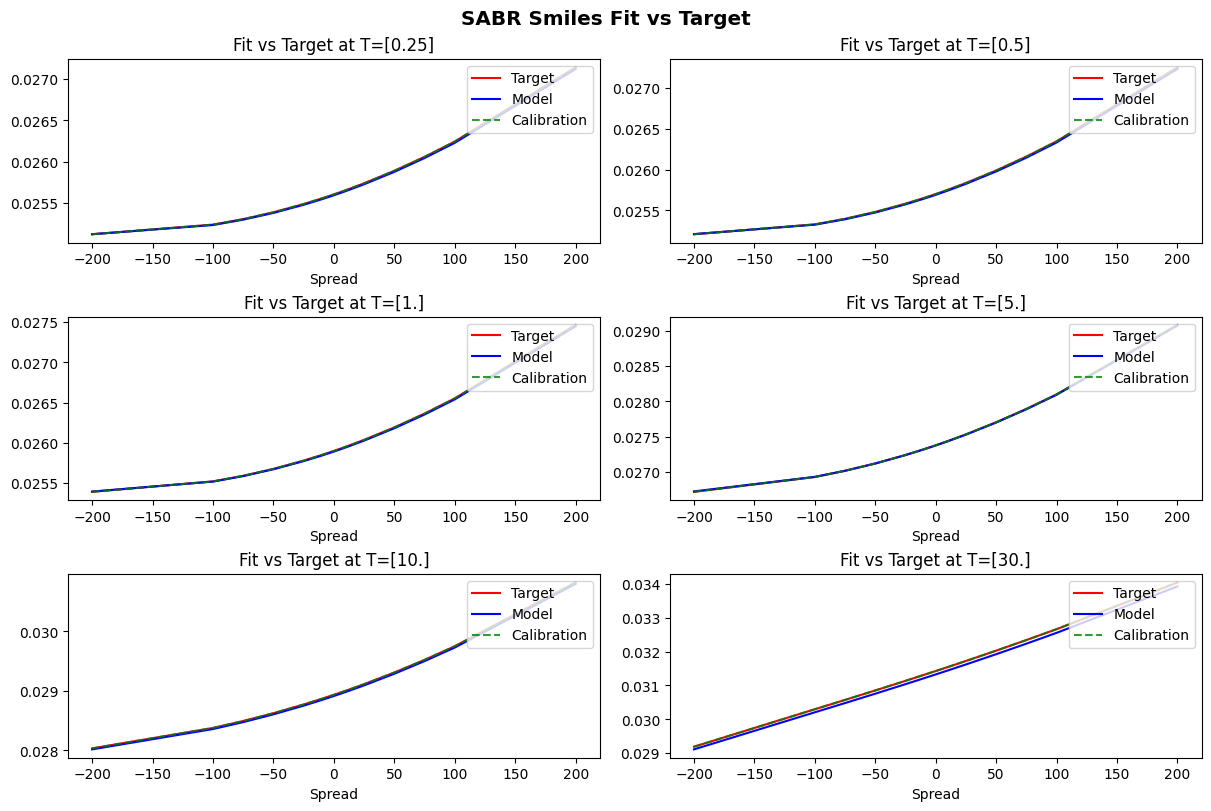

In [ ]:
if USE_PRETRAINED or TRAIN:
    print("> Choosing a sample parameter set to display chart")
    NUM_STRIKES = 100
    PARAMS = { 'LnVol': 0.30, 'Beta': 0.5, 'Nu': 0.50, 'Rho': -0.10 }
    FWD = 0.055

    # Any number of expiries can be calculated, but for optimum display choose no more than 6
    EXPIRIES = np.asarray([0.25, 0.50, 1.0, 5.0, 10.0, 30.0]).reshape(-1, 1)
    NUM_EXPIRIES = EXPIRIES.shape[0]

    # Calculate market strikes and prices on the training spreads
    TRAINING_SPREADS = SPREADS
    TRAINING_SPREADS = np.asarray(TRAINING_SPREADS)
    TRAINING_SPREADS = np.tile(TRAINING_SPREADS, (NUM_EXPIRIES, 1))
    mkt_strikes = TRAINING_SPREADS / 10000.0 + FWD

    # Calculate market prices and vols
    mkt_vols = generator.price_straddles_ref(EXPIRIES, mkt_strikes, FWD, PARAMS, True)
    mkt_prices = generator.price_straddles_ref(EXPIRIES, mkt_strikes, FWD, PARAMS, False)

    # Use model to get parameters at each expiry, then calculate parameters and then prices
    mod_timer = Stopwatch("Model")
    mod_timer.trigger()
    mod_params, mod_vols = generator.price_straddles_mod(model, EXPIRIES, mkt_strikes, FWD,
                                                         mkt_vols, True)
    mod_timer.stop()

    rmse_mkt_mod = bps_rmse(mkt_vols, mod_vols)

    # Calibrate prices by optimization
    opt_timer = Stopwatch("Optimization")
    opt_timer.trigger()
    weights = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
    cal_params, cal_vols = generator.calibrate(EXPIRIES, mkt_strikes, FWD, mkt_prices, weights, True)
    opt_timer.stop()
    rmse_mkt_cal = bps_rmse(mkt_vols, cal_vols)
    print(f"RMSE market-model: {rmse_mkt_mod:,.2f}")
    print(f"RMSE market-calibration: {rmse_mkt_cal:,.2f}")
    mod_timer.print()
    opt_timer.print()

    # Calculate speed gain factor
    mod_time = mod_timer.elapsed()
    opt_time = opt_timer.elapsed()
    ratio = opt_time / mod_time
    print(f"Speed gain factor: {ratio:,}x")

    # Display parameters
    data = {'Expiry': EXPIRIES[:, 0]}
    df = pd.DataFrame(data)
    df['LnVol-TGT'] = [PARAMS['LnVol']] * NUM_EXPIRIES
    df['LnVol-MOD'] = [x['LnVol'] for x in mod_params]
    df['LnVol-CAL'] = [x['LnVol'] for x in cal_params]
    print(df.to_string(index=False))
    df = pd.DataFrame(data)
    df['Beta-TGT'] = [PARAMS['Beta']] * NUM_EXPIRIES
    df['Beta-MOD'] = [x['Beta'] for x in mod_params]
    df['Beta-CAL'] = [x['Beta'] for x in cal_params]
    print(df.to_string(index=False))
    df = pd.DataFrame(data)
    df['Nu-TGT'] = [PARAMS['Nu']] * NUM_EXPIRIES
    df['Nu-MOD'] = [x['Nu'] for x in mod_params]
    df['Nu-CAL'] = [x['Nu'] for x in cal_params]
    print(df.to_string(index=False))
    df = pd.DataFrame(data)
    df['Rho-TGT'] = [PARAMS['Rho']] * NUM_EXPIRIES
    df['Rho-MOD'] = [x['Rho'] for x in mod_params]
    df['Rho-CAL'] = [x['Rho'] for x in cal_params]
    print(df.to_string(index=False))

    # Plot
    fig, axs = plt.subplots(3, 2, layout="constrained")
    fig.suptitle("SABR Smiles Fit vs Target", size='x-large', weight='bold')
    fig.set_size_inches(12, 8)
    plot_spreads = TRAINING_SPREADS[0]

    axs[0, 0].plot(plot_spreads, mkt_vols[0], color='red', label='Target')
    axs[0, 0].plot(plot_spreads, mod_vols[0], color='blue', label='Model')
    axs[0, 0].plot(plot_spreads, cal_vols[0], 'g--', alpha=0.8, label='Calibration')
    axs[0, 0].set_xlabel('Spread')
    axs[0, 0].set_title(f"Fit vs Target at T={EXPIRIES[0]}")
    axs[0, 0].legend(loc='upper right')

    axs[0, 1].plot(plot_spreads, mkt_vols[1], color='red', label='Target')
    axs[0, 1].plot(plot_spreads, mod_vols[1], color='blue', label='Model')
    axs[0, 1].plot(plot_spreads, cal_vols[1], 'g--', alpha=0.8, label='Calibration')
    axs[0, 1].set_xlabel('Spread')
    axs[0, 1].set_title(f"Fit vs Target at T={EXPIRIES[1]}")
    axs[0, 1].legend(loc='upper right')

    axs[1, 0].plot(plot_spreads, mkt_vols[2], color='red', label='Target')
    axs[1, 0].plot(plot_spreads, mod_vols[2], color='blue', label='Model')
    axs[1, 0].plot(plot_spreads, cal_vols[2], 'g--', alpha=0.8, label='Calibration')
    axs[1, 0].set_xlabel('Spread')
    axs[1, 0].set_title(f"Fit vs Target at T={EXPIRIES[2]}")
    axs[1, 0].legend(loc='upper right')

    axs[1, 1].plot(plot_spreads, mkt_vols[3], color='red', label='Target')
    axs[1, 1].plot(plot_spreads, mod_vols[3], color='blue', label='Model')
    axs[1, 1].plot(plot_spreads, cal_vols[3], 'g--', alpha=0.8, label='Calibration')
    axs[1, 1].set_xlabel('Spread')
    axs[1, 1].set_title(f"Fit vs Target at T={EXPIRIES[3]}")
    axs[1, 1].legend(loc='upper right')

    axs[2, 0].plot(plot_spreads, mkt_vols[4], color='red', label='Target')
    axs[2, 0].plot(plot_spreads, mod_vols[4], color='blue', label='Model')
    axs[2, 0].plot(plot_spreads, cal_vols[4], 'g--', alpha=0.8, label='Calibration')
    axs[2, 0].set_xlabel('Spread')
    axs[2, 0].set_title(f"Fit vs Target at T={EXPIRIES[4]}")
    axs[2, 0].legend(loc='upper right')

    axs[2, 1].plot(plot_spreads, mkt_vols[5], color='red', label='Target')
    axs[2, 1].plot(plot_spreads, mod_vols[5], color='blue', label='Model')
    axs[2, 1].plot(plot_spreads, cal_vols[5], 'g--', alpha=0.8, label='Calibration')
    axs[2, 1].set_xlabel('Spread')
    axs[2, 1].set_title(f"Fit vs Target at T={EXPIRIES[5]}")
    axs[2, 1].legend(loc='upper right')

    plt.show()

Display training history

[[0.02511616 0.02523336 0.02530008 0.02538324 0.02548331 0.02555161
  0.02560061 0.02565238 0.02573526 0.02588726 0.02605642 0.0262424
  0.02714408]
 [0.02520815 0.02532943 0.02539712 0.02548124 0.02558227 0.02565115
  0.02570054 0.02575271 0.02583618 0.02598919 0.02615936 0.0263464
  0.02725252]
 [0.02538965 0.0255194  0.02558906 0.02567514 0.02577814 0.0258482
  0.02589838 0.02595134 0.02603601 0.02619104 0.02636328 0.02655242
  0.02746743]
 [0.02671667 0.0269271  0.02701498 0.02711883 0.02723927 0.0273197
  0.02737677 0.0274366  0.02753156 0.02770372 0.02789316 0.0280996
  0.02908559]
 [0.02803288 0.02837697 0.02849367 0.02862497 0.0287717  0.02886742
  0.02893449 0.02900421 0.02911376 0.0293097  0.02952234 0.02975152
  0.03082526]
 [0.02919444 0.03029916 0.03057446 0.03085301 0.03113627 0.03130903
  0.03142552 0.03154313 0.03172179 0.03202591 0.03233848 0.03265991
  0.03403622]]
[[0.02511577 0.02523599 0.02529872 0.02538727 0.02547573 0.02552622
  0.02561988 0.02565106 0.02575664 0

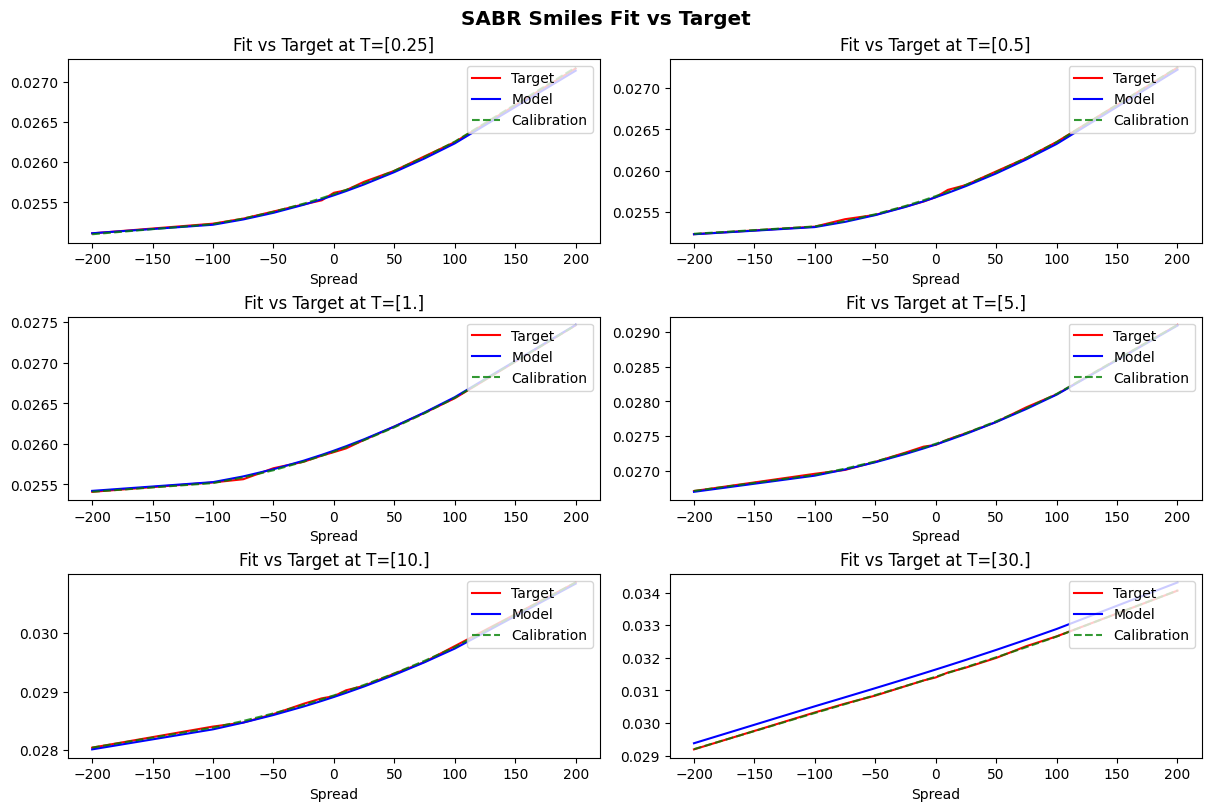

In [ ]:
from sdevpy.analytics import bachelier
def price_mkt_straddles(expiries, strikes, fwd, nvols):
    expiries_ = np.asarray(expiries).reshape(-1, 1)
    shifted_k = strikes + SHIFT
    shifted_f = fwd + SHIFT
    prices = []
    for i, expiry in enumerate(expiries_):
        k_prices = []
        for j, sk in enumerate(shifted_k[i]):
            iv = nvols[i, j]
            call_price = bachelier.price(expiry, sk, True, shifted_f, iv)
            put_price = bachelier.price(expiry, sk, False, shifted_f, iv)
            k_prices.append(call_price[0] + put_price[0])
        prices.append(k_prices)

    return np.asarray(prices)

# Add noise to market vols
rel_noise = 0.001
shape = mkt_vols.shape
# print(mkt_vols)
rand_mat = np.random.rand(shape[0], shape[1])
noise = (rand_mat - 0.5) * rel_noise / 0.5
noise_mkt_vols = mkt_vols * (1.0 + noise)

print(mkt_vols)
print(noise_mkt_vols)
print("noise diff in bps")
print((noise_mkt_vols - mkt_vols) * 10000)

# Calculate prices
noise_mkt_prices = price_mkt_straddles(EXPIRIES, mkt_strikes, FWD, noise_mkt_vols)
# print(noise_mkt_prices)

# Use model to get parameters at each expiry, then calculate parameters and then prices
noise_mod_timer = Stopwatch("Model")
noise_mod_timer.trigger()
noise_mod_params, noise_mod_vols = generator.price_straddles_mod(model, EXPIRIES, mkt_strikes, FWD,
                                                                 noise_mkt_vols, True)
noise_mod_timer.stop()

# Display parameters
data = {'Expiry': EXPIRIES[:, 0]}
df = pd.DataFrame(data)
df['LnVol-TGT'] = [PARAMS['LnVol']] * NUM_EXPIRIES
df['LnVol-MOD'] = [x['LnVol'] for x in noise_mod_params]
# df['LnVol-CAL'] = [x['LnVol'] for x in cal_params]
print(df.to_string(index=False))
df = pd.DataFrame(data)
df['Beta-TGT'] = [PARAMS['Beta']] * NUM_EXPIRIES
df['Beta-MOD'] = [x['Beta'] for x in noise_mod_params]
# df['Beta-CAL'] = [x['Beta'] for x in cal_params]
print(df.to_string(index=False))
df = pd.DataFrame(data)
df['Nu-TGT'] = [PARAMS['Nu']] * NUM_EXPIRIES
df['Nu-MOD'] = [x['Nu'] for x in noise_mod_params]
# df['Nu-CAL'] = [x['Nu'] for x in cal_params]
print(df.to_string(index=False))
df = pd.DataFrame(data)
df['Rho-TGT'] = [PARAMS['Rho']] * NUM_EXPIRIES
df['Rho-MOD'] = [x['Rho'] for x in noise_mod_params]
# df['Rho-CAL'] = [x['Rho'] for x in cal_params]
print(df.to_string(index=False))

print("model nvols")
print(noise_mod_vols)
noise_rmse_mkt_mod = bps_rmse(noise_mkt_vols, noise_mod_vols)

# Calibrate prices by optimization
noise_opt_timer = Stopwatch("Optimization")
noise_opt_timer.trigger()
weights = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
noise_cal_params, noise_cal_vols = generator.calibrate(EXPIRIES, mkt_strikes, FWD, noise_mkt_prices,
                                                       weights, True)
noise_opt_timer.stop()
noise_rmse_mkt_cal = bps_rmse(noise_mkt_vols, noise_cal_vols)
print(f"RMSE market-model: {noise_rmse_mkt_mod:,.2f}")
print(f"RMSE market-calibration: {noise_rmse_mkt_cal:,.2f}")
noise_mod_timer.print()
noise_opt_timer.print()

# Calculate speed gain factor
noise_mod_time = noise_mod_timer.elapsed()
noise_opt_time = noise_opt_timer.elapsed()
noise_ratio = noise_opt_time / noise_mod_time
print(f"Speed gain factor: {noise_ratio:,}x")

# Plot
fig, axs = plt.subplots(3, 2, layout="constrained")
fig.suptitle("SABR Smiles Fit vs Target", size='x-large', weight='bold')
fig.set_size_inches(12, 8)
plot_spreads = TRAINING_SPREADS[0]

axs[0, 0].plot(plot_spreads, noise_mkt_vols[0], color='red', label='Target')
axs[0, 0].plot(plot_spreads, noise_mod_vols[0], color='blue', label='Model')
axs[0, 0].plot(plot_spreads, noise_cal_vols[0], 'g--', alpha=0.8, label='Calibration')
axs[0, 0].set_xlabel('Spread')
axs[0, 0].set_title(f"Fit vs Target at T={EXPIRIES[0]}")
axs[0, 0].legend(loc='upper right')

axs[0, 1].plot(plot_spreads, noise_mkt_vols[1], color='red', label='Target')
axs[0, 1].plot(plot_spreads, noise_mod_vols[1], color='blue', label='Model')
axs[0, 1].plot(plot_spreads, noise_cal_vols[1], 'g--', alpha=0.8, label='Calibration')
axs[0, 1].set_xlabel('Spread')
axs[0, 1].set_title(f"Fit vs Target at T={EXPIRIES[1]}")
axs[0, 1].legend(loc='upper right')

axs[1, 0].plot(plot_spreads, noise_mkt_vols[2], color='red', label='Target')
axs[1, 0].plot(plot_spreads, noise_mod_vols[2], color='blue', label='Model')
axs[1, 0].plot(plot_spreads, noise_cal_vols[2], 'g--', alpha=0.8, label='Calibration')
axs[1, 0].set_xlabel('Spread')
axs[1, 0].set_title(f"Fit vs Target at T={EXPIRIES[2]}")
axs[1, 0].legend(loc='upper right')

axs[1, 1].plot(plot_spreads, noise_mkt_vols[3], color='red', label='Target')
axs[1, 1].plot(plot_spreads, noise_mod_vols[3], color='blue', label='Model')
axs[1, 1].plot(plot_spreads, noise_cal_vols[3], 'g--', alpha=0.8, label='Calibration')
axs[1, 1].set_xlabel('Spread')
axs[1, 1].set_title(f"Fit vs Target at T={EXPIRIES[3]}")
axs[1, 1].legend(loc='upper right')

axs[2, 0].plot(plot_spreads, noise_mkt_vols[4], color='red', label='Target')
axs[2, 0].plot(plot_spreads, noise_mod_vols[4], color='blue', label='Model')
axs[2, 0].plot(plot_spreads, noise_cal_vols[4], 'g--', alpha=0.8, label='Calibration')
axs[2, 0].set_xlabel('Spread')
axs[2, 0].set_title(f"Fit vs Target at T={EXPIRIES[4]}")
axs[2, 0].legend(loc='upper right')

axs[2, 1].plot(plot_spreads, noise_mkt_vols[5], color='red', label='Target')
axs[2, 1].plot(plot_spreads, noise_mod_vols[5], color='blue', label='Model')
axs[2, 1].plot(plot_spreads, noise_cal_vols[5], 'g--', alpha=0.8, label='Calibration')
axs[2, 1].set_xlabel('Spread')
axs[2, 1].set_title(f"Fit vs Target at T={EXPIRIES[5]}")
axs[2, 1].legend(loc='upper right')

plt.show()

In [ ]:
import numpy as np
a = 2
rel = 0.05
n = np.random.rand()
print(n)

0.7586728577898606
